In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

## Load data and separate train from test-phase

There are cases where load and temp data are missing due to a blackout (see Known_Artifacts.md for an inexhaustive list)

We need to impute the temperature data to use it for training ARIMA-type models. We did NOT need this for the univariate model since complete data is only assumed for covariate (not the outcome).

In [10]:
base_data = pd.read_csv('data.csv', index_col=0)
base_data.index = pd.to_datetime(base_data.index)
base_data = base_data.asfreq('H')

imputed_data = base_data.copy()
for idx, row in imputed_data.iterrows():
    if np.isnan(row.tmp_f_KDFW):
        imputed_data.loc[idx].tmp_f_KDFW = base_data[
                                                    (base_data.index.month == idx.month) & 
                                                    (base_data.index.day == idx.day) & 
                                                    (base_data.index.hour == idx.hour)
                                                ].tmp_f_KDFW.mean()

In [19]:
train_data = imputed_data[imputed_data.index < '2021-07-01']
train_data = train_data.asfreq('H')
target_data = imputed_data[imputed_data.index > '2021-06-30']
target_data = target_data.asfreq('H')

# First Pass

## AR(12) Model

Since we're going to have temperature data included, we can likely reduce the number of parameters (reduce overfitting) and stop using the moving average and integration components

In [20]:
# Construct the model
mod = sm.tsa.SARIMAX(endog=train_data.north_load, exog=train_data.tmp_f_KDFW, order=(12, 0, 0), trend='c')

# Estimate the parameters
res = mod.fit()

print(res.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33769D+00    |proj g|=  5.22302D-02

At iterate    5    f=  7.33401D+00    |proj g|=  1.71522D-03

At iterate   10    f=  7.33086D+00    |proj g|=  3.15604D-02

At iterate   15    f=  7.14927D+00    |proj g|=  1.37185D-01

At iterate   20    f=  7.10799D+00    |proj g|=  5.11798D-02

At iterate   25    f=  7.09204D+00    |proj g|=  1.37215D-02

At iterate   30    f=  7.09137D+00    |proj g|=  1.84211D-03

At iterate   35    f=  7.09129D+00    |proj g|=  4.38694D-03

At iterate   40    f=  7.08942D+00    |proj g|=  3.69421D-02

At iterate   45    f=  7.08351D+00    |proj g|=  1.54268D-02


KeyboardInterrupt: 

### Get Results Through 10/31/21

In [43]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(target_data.index[-1])

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

north_load                         mean      mean_se  mean_ci_lower  \
2021-07-01 00:00:00-06:00  14793.132128   281.973538   14329.326930   
2021-07-01 01:00:00-06:00  13567.582061   689.467362   12433.509169   
2021-07-01 02:00:00-06:00  12770.656089  1120.156291   10928.162951   
2021-07-01 03:00:00-06:00  12361.266169  1544.437571    9820.892430   
2021-07-01 04:00:00-06:00  12323.596301  1953.788902    9109.899539   
...                                 ...          ...            ...   
2021-10-31 19:00:00-06:00  15268.995373  3873.768577    8897.213080   
2021-10-31 20:00:00-06:00  15268.995373  3873.768577    8897.213080   
2021-10-31 21:00:00-06:00  15268.995373  3873.768577    8897.213080   
2021-10-31 22:00:00-06:00  15268.995373  3873.768577    8897.213080   
2021-10-31 23:00:00-06:00  15268.995373  3873.768577    8897.213080   

north_load                 mean_ci_upper  
2021-07-01 00:00:00-06:00   15256.937325  
2021-07-01 01:00:00-06:00   14701.654952  
2021-07-01 02:00:0

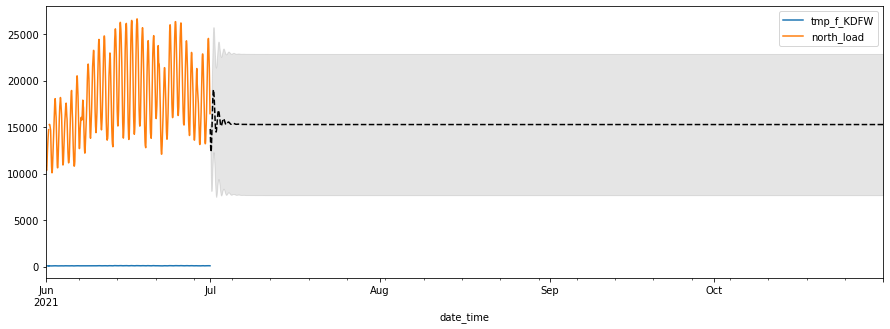

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2021-06-01':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);